In [1]:
import pygrib
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from icedef import metocean, test_case, simulator

from importlib import reload

# Airport Winds

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# airport_data_path = '/home/evankielley/Downloads/eng-hourly-04012015-04302015.csv'
airport_data_path = 'http://icedef.munroelab.ca/data/StJohnsAirport/stjohns_airport_april_2015.csv'

df = pd.read_csv(airport_data_path, 
                  usecols=['Date/Time', 'Wind Spd (km/h)', 'Wind Dir (10s deg)'], skiprows=15)

In [3]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Wind Dir (deg)'] = df['Wind Dir (10s deg)'] * 10
df['Wind Spd (m/s)'] = df['Wind Spd (km/h)'] * (1000 / 3600)
df['Wind Dir (rad)'] = np.deg2rad(df['Wind Dir (deg)'])
df['eastward_wind_velocity'] =  -df['Wind Spd (m/s)'] * np.sin(df['Wind Dir (rad)'])
df['northward_wind_velocity'] =  -df['Wind Spd (m/s)'] * np.cos(df['Wind Dir (rad)'])

In [4]:
df

,Date/Time,Wind Dir (10s deg),Wind Spd (km/h),Wind Dir (deg),Wind Spd (m/s),Wind Dir (rad),eastward_wind_velocity,northward_wind_velocity
0,2015-04-01 00:30:00,19,21,190,5.833,3.316,1.013,5.745
1,2015-04-01 01:30:00,22,25,220,6.944,3.840,4.464,5.320
2,2015-04-01 02:30:00,21,21,210,5.833,3.665,2.917,5.052
3,2015-04-01 03:30:00,23,37,230,10.278,4.014,7.873,6.606
4,2015-04-01 04:30:00,24,43,240,11.944,4.189,10.344,5.972
5,2015-04-01 05:30:00,25,48,250,13.333,4.363,12.529,4.560
6,2015-04-01 06:30:00,26,37,260,10.278,4.538,10.122,1.785
7,2015-04-01 07:30:00,26,37,260,10.278,4.538,10.122,1.785
8,2015-04-01 08:30:00,26,42,260,11.667,4.538,11.489,2.026
9,2015-04-01 09:30:00,25,43,250,11.944,4.363,11.224,4.085


In [5]:
start_date = np.datetime64('2015-04-19')
end_date = np.datetime64('2015-04-20')
date_bounds = start_date, end_date
atm = metocean.NARRAtmosphere(date_bounds)

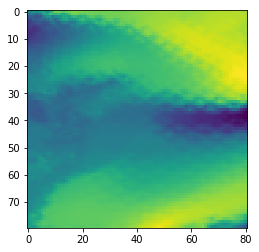

In [6]:
plt.imshow(atm.eastward_wind_velocities[0, :, :])

In [7]:
start_index = np.where(df['Date/Time'] > atm.dataset.time.values[0])[0][0]
end_index = np.where(df['Date/Time'] < atm.dataset.time.values[-1])[0][-1]

In [8]:
latitude, longitude = 47.6212, -52.7424  # St. John's International Airport

d = {'time': [], 'obs_u': [], 'obs_v': [], 'mod_u': [], 'mod_v': []}

for i in range(start_index, end_index + 1):

    time = np.datetime64(df['Date/Time'][i])
    d['time'].append(time)
    d['obs_u'].append(df['eastward_wind_velocity'][i])
    d['obs_v'].append(df['northward_wind_velocity'][i])
    d['mod_u'].append(float(atm.eastward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                         assume_sorted=True).values))
    d['mod_v'].append(float(atm.northward_wind_velocities.interp(time=time, latitude=latitude, longitude=longitude, 
                                                         assume_sorted=True).values))

In [9]:
d['time'][-1]

numpy.datetime64('2015-04-21T20:30:00.000000')

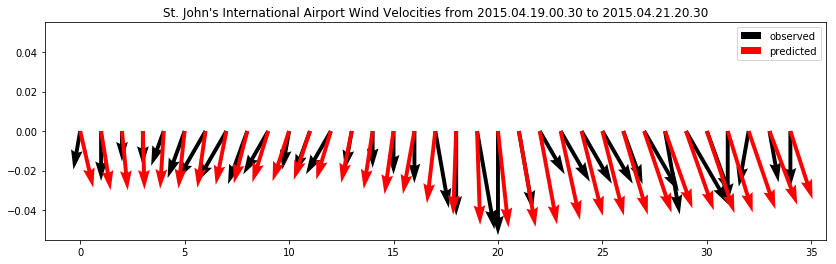

In [10]:
gap = 2
plt.figure(figsize=(14, 4))
plt.quiver(d['obs_u'][::gap], d['obs_v'][::gap], width=5e-3, scale=100, color='black', label='observed')
plt.quiver(d['mod_u'][::gap], d['mod_v'][::gap], width=5e-3, scale=100, color='red', label='predicted')
plt.title('St. John\'s International Airport Wind Velocities from {} to {}'.format(
    pd.to_datetime(str(d['time'][0])).strftime('%Y.%m.%d.%H.%M'), 
    pd.to_datetime(str(d['time'][-1])).strftime('%Y.%m.%d.%H.%M')))
plt.legend()
plt.show()

# Ocean Model Data

In [11]:
start_date = np.datetime64('2015-04-19')
end_date = np.datetime64('2015-04-30')
date_bounds = start_date, end_date

ecmwf_ocean = metocean.ECMWFOcean(date_bounds)
ecmwf_eastward_velocities = ecmwf_ocean.eastward_velocities
ecmwf_northward_current_velocities = ecmwf_ocean.northward_current_velocities

hycom_ocean = metocean.HYCOMOcean(date_bounds)
hycom_eastward_velocities = hycom_ocean.eastward_velocities
hycom_northward_current_velocities = hycom_ocean.northward_current_velocities

# ADCP & AVOS

In [ ]:
file_loc, message = urlretrieve('http://icedef.munroelab.ca/data/StatoilArcticNet/Leg1_1501_ADCP/an1501_os150bb.nc')
adcp_ds = xr.open_dataset(file_loc)

In [ ]:
avos_df = pd.read_csv('http://icedef.munroelab.ca/data/StatoilArcticNet/AVOS_2015.csv', sep=' ; ')
bad_rows = np.where((avos_df['Longitude'] > 180) | (avos_df['Longitude'] < -180) |
                    (avos_df['Latitude'] > 180) | (avos_df['Latitude'] < -180))[0]

avos_df = avos_df.drop(avos_df.index[bad_rows])
avos_df['Date'] = avos_df['Date'].str.replace('/', '-')
avos_df['Date'] = pd.to_datetime(avos_df['Date'])
avos_df['Wind speed'] = pd.to_numeric(avos_df['Wind speed'])
avos_df['Wind dir'] = pd.to_numeric(avos_df['Wind dir'])

avos_ds = avos_df.set_index('Date').to_xarray()

In [ ]:
adcp_subset = adcp_ds.where((adcp_ds.lat < 60) & (adcp_ds.lat > 40) & \
                            (adcp_ds.lon < -40) & (adcp_ds.lon > -60) & \
                            (adcp_ds.u < 10) & (adcp_ds.u > -10) & \
                            (adcp_ds.v < 10) & (adcp_ds.v > -10), drop=True)

avos_subset = avos_ds.where((avos_ds['Latitude'] < 60) & (avos_ds['Latitude'] > 40) & \
                           (avos_ds['Longitude'] < -40) & (avos_ds['Longitude'] > -60), drop=True)

avos_subset = avos_subset.where(avos_subset['Date'] < adcp_subset['time'].values[-1], drop=True)

min_time = max([avos_subset['Date'].min(), adcp_ds['time'].min()]).values
max_time = min([avos_subset['Date'].max(), adcp_ds['time'].max()]).values

adcp_subset = adcp_subset.where((adcp_subset['time'] >= min_time) & (adcp_subset['time'] <= max_time), drop=True)
avos_subset = avos_subset.where((avos_subset['Date'] >= min_time) & (avos_subset['Date'] <= max_time), drop=True)

In [ ]:
adcp_subset.time.values[0], adcp_subset.time.values[-1], avos_subset['Date'].values[0], avos_subset['Date'].values[-1]

# Compare By Interpolating

In [ ]:
time_list = []
latitude_list = []
longitude_list = []
hycom_eastward_current_velocity_list = []
ecmwf_eastward_current_velocity_list = []
adcp_eastward_current_velocity_list = []
hycom_northward_current_velocity_list = []
ecmwf_northward_current_velocity_list = []
adcp_northward_current_velocity_list = []

for i in range(100):

    time = adcp_subset.time.values[i]
    latitude = adcp_subset.lat.values[i, 0]
    longitude = adcp_subset.lon.values[i, 0]

    try:
        hycom_eastward_current_velocity = hycom_eastward_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        
        ecmwf_eastward_current_velocity = ecmwf_eastward_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        adcp_eastward_current_velocity = adcp_subset.u[i, 0]
        
        hycom_northward_current_velocity = hycom_northward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        
        ecmwf_northward_current_velocity = ecmwf_northward_current_velocities.interp(time=time, 
                                                                                   latitude=latitude, 
                                                                                   longitude=longitude,
                                                                                   assume_sorted=True)
        adcp_northward_current_velocity = adcp_subset.v[i, 0]
        
        time_list.append(time)
        latitude_list.append(latitude)
        longitude_list.append(longitude)
        hycom_eastward_current_velocity_list.append(hycom_eastward_current_velocity)
        ecmwf_eastward_current_velocity_list.append(ecmwf_eastward_current_velocity)
        adcp_eastward_current_velocity_list.append(adcp_eastward_current_velocity)
        hycom_northward_current_velocity_list.append(hycom_northward_current_velocity)
        ecmwf_northward_current_velocity_list.append(ecmwf_northward_current_velocity)
        adcp_northward_current_velocity_list.append(adcp_northward_current_velocity)

    except KeyError:
        print(f"NaN at index {i}")
        pass

In [ ]:
gap = 5
scale = 2
width = 5e-3
headwidth = 2

plt.figure(figsize=(12, 6))

plt.quiver(hycom_eastward_current_velocity_list[::gap], 
           hycom_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='black', label='HYCOM')

plt.quiver(ecmwf_eastward_current_velocity_list[::gap], 
           ecmwf_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='red', label='ECMWF')

plt.quiver(adcp_eastward_current_velocity_list[::gap], 
           adcp_northward_current_velocity_list[::gap], 
           scale=scale, width=width, headwidth=headwidth, color='blue', label='ADCP')

plt.legend()
plt.show()

In [ ]:
plt.plot(hycom_eastward_current_velocity_list, label='HYCOM')
plt.plot(ecmwf_eastward_current_velocity_list, label='ECMWF')
plt.plot(adcp_eastward_current_velocity_list, label='ADCP')
plt.legend()
plt.show()

# Simulator

In [ ]:
tc = test_case.TestCase(index_range=(867, 914))
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

In [ ]:
sim = simulator.Simulator()

sim.run_simulation(start_location, time_frame, store_results_as='ECMWF')
sim.ocean_model = metocean.HYCOMOcean
sim.run_simulation(start_location, time_frame, store_results_as='HYCOM')

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(ref_lons, ref_lats, '.-', label='observed')
plt.plot(sim.results['ECMWF']['longitude'], sim.results['ECMWF']['latitude'], '.-', label='ECMWF')
plt.plot(sim.results['HYCOM']['longitude'], sim.results['HYCOM']['latitude'], '.-', label='HYCOM')
plt.legend()
plt.show()

# Old Code

In [ ]:
grbs = pygrib.open('/home/evankielley/Downloads/ofs_atl.t00z.N000.20150420.3d.grb.grib2')

In [ ]:
for grb in grbs[:2]:
    print(grb)

In [ ]:
grbs